In [1]:
# !pip install streamlit

In [2]:
# !pip install bokeh

In [3]:
# pip install streamlit

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
# import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, ConvLSTM2D,Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, concatenate,Concatenate,Permute,dot,multiply,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import plotly
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType
import plotly.express as px
import plotly.graph_objects as go
from tensorflow.keras.metrics import RootMeanSquaredError
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_squared_error
import pickle
from pyspark.sql.functions import col, lit, concat_ws, collect_set
from pyspark.sql import SparkSession
import findspark
from pyspark.context import SparkContext
warnings.filterwarnings('ignore')
from pyspark.sql.types import TimestampType, StructField, StringType, IntegerType, StructType, DoubleType

In [2]:
findspark.init()
findspark.find()

'C:\\Users\\idaas\\anaconda3\\envs\\pyspark-env\\lib\\site-packages\\pyspark'

In [4]:
# Importar las bibliotecas necesarias
sc = SparkContext.getOrCreate()
# Primera sesión de Spark
spark = SparkSession.builder \
    .appName("Trufi") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.driver.host", "localhost") \
    .config("spark.master", "local") \
    .getOrCreate()

# Configurar el número de particiones
spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.sparkContext

<SparkContext master=local[*] appName=Trufi>

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from datetime import datetime, timedelta
import findspark

findspark.init()
# Crear la sesión de Spark
spark = SparkSession.builder.appName("Trufi").getOrCreate()

# Ruta del archivo CSV
datasetmerged = "D:/Trufiapp/GANS/datasetmerged/datasetmerged.csv"

# Leer el archivo CSV en un DataFrame de Spark
df_spark = spark.read.csv("file:///" + datasetmerged, header=True, inferSchema=True)
# df_spark.printSchema()
# df_spark.show()

In [519]:
data_completed_spark_data

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

DataFrame[hourly_timestamp: string, origin_request_count: double, OriginLocationID: double, destination_request_count: double, Holiday_n: double, windspeed: double, cloudcover: double, precip: double, humidity: double, temp: double, isWeekend: double, DayOfWeek: double, Hour: double, DayOfMonth: double, Month: double, Year: double, h3_index: string, id: int, latitude: double, longitude: double]

In [516]:
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql import functions as F
# Fecha de inicio
start_date = datetime(2023, 12, 16)
previous_date = datetime(2023, 12, 13)
last_date_prediction = datetime(2023, 12, 24)

# Filtrar datos en Spark desde start_date hasta tres días antes
filtered_spark_data = df_spark.filter((col("hourly_timestamp") <= start_date) & (col("hourly_timestamp") >= previous_date))
data_completed_spark_data = df_spark.filter((col("hourly_timestamp") <= last_date_prediction) & (col("hourly_timestamp") >= previous_date))

# Convertir la columna de fecha y hora a un tipo datetime64[ns]
filtered_spark_data = filtered_spark_data.withColumn('hourly_timestamp', to_timestamp(col('hourly_timestamp')))
data_completed_spark_data = data_completed_spark_data.withColumn('hourly_timestamp', to_timestamp(col('hourly_timestamp')))

# Formatear la columna 'hourly_timestamp'
filtered_spark_data = filtered_spark_data.withColumn('hourly_timestamp', F.date_format('hourly_timestamp', 'yyyy-MM-dd HH:mm:ss'))
filtered_spark_data = filtered_spark_data.orderBy('hourly_timestamp')
data_completed_spark_data = data_completed_spark_data.withColumn('hourly_timestamp', F.date_format('hourly_timestamp', 'yyyy-MM-dd HH:mm:ss'))
data_completed_spark_data = data_completed_spark_data.orderBy('hourly_timestamp')


# Convertir el DataFrame de Spark a pandas para realizar operaciones en pandas
real_data = filtered_spark_data.toPandas()
data_completed = data_completed_spark_data.toPandas()

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [517]:
data_completed

datetime  origin_request_count  OriginLocationID  \
14     2023-12-13 00:00:00                   0.0               5.0   
18     2023-12-13 00:00:00                   3.0               8.0   
21     2023-12-13 00:00:00                   0.0              11.0   
33     2023-12-13 00:00:00                   0.0               6.0   
34     2023-12-13 00:00:00                   0.0               7.0   
...                    ...                   ...               ...   
15588  2023-12-24 00:00:00                   0.0               7.0   
15605  2023-12-24 00:00:00                   0.0               6.0   
15619  2023-12-24 00:00:00                   0.0               5.0   
15621  2023-12-24 00:00:00                   2.0               8.0   
15624  2023-12-24 00:00:00                   0.0              11.0   

       destination_request_count  Holiday_n  windspeed  cloudcover  precip  \
14                           2.0        0.0       11.2        89.0     0.0   
18                           3.0        0.0       11.2        89.0     0.0   
21                           0.0        0.0       11.2        89.0     0.0   
33                           0.0        0.0       11.2        89.0     0.0   
34                           3.0        0.0       11.2        89.0     0.0   
...                          ...        ...        ...         ...     ...   
15588                        0.0        0.0       14.8        88.0     0.0   
15605                        1.0        0.0       14.8        88.0     0.0   
15619                        0.0        0.0       14.8        88.0     0.0   
15621                        0.0        0.0       14.8        88.0     0.0   
15624                        0.0        0.0       14.8        88.0     0.0   

       humidity  temp  isWeekend  DayOfWeek  Hour  DayOfMonth  Month    Year  \
14        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
18        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
21        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
33        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
34        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
...         ...   ...        ...        ...   ...         ...    ...     ...   
15588     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15605     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15619     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15621     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15624     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   

              h3_index  id   latitude  longitude  
14     878b2c98affffff   5 -17.455051 -66.153015  
18     878b2c8acffffff   8 -17.386101 -66.188359  
21     878b2c99dffffff  11 -17.466841 -66.133964  
33     878b2c998ffffff   6 -17.455962 -66.113539  
34     878b2c8a8ffffff   7 -17.363420 -66.186976  
...                ...  ..        ...        ...  
15588  878b2c8a8ffffff   7 -17.363420 -66.186976  
15605  878b2c998ffffff   6 -17.455962 -66.113539  
15619  878b2c98affffff   5 -17.455051 -66.153015  
15621  878b2c8acffffff   8 -17.386101 -66.188359  
15624  878b2c99dffffff  11 -17.466841 -66.133964  

[1325 rows x 20 columns]

In [156]:
%%writefile streamlit_app.py


pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

from bokeh.io import output_notebook, output_file, show
from bokeh.plotting import figure
from bokeh.models import HoverTool, Select, ColumnDataSource, WheelZoomTool, LogColorMapper, LinearColorMapper, ColorBar, BasicTicker
from bokeh.palettes import Viridis256 as palette
from bokeh.layouts import row
import altair as alt

import streamlit as st
import pandas as pd
import numpy as np

Overwriting streamlit_app.py


In [157]:
from datetime import date, timedelta, datetime
# DECLARE VARIABLES: start date, NoOfDays, pickle_file
start_date = datetime(2023, 12, 16)  # start day is tomorrow
NoOfDays = 8  # number of days for prediction
pickle_file = './model_regGB.pickle'
start_date

datetime.datetime(2023, 12, 16, 0, 0)

In [158]:
import pandas as pd
def get_LocationIDs():
    # 1. Import Location and Borough columns form NY TAXI ZONES dataset
    dfzones = pd.read_csv('./id_index_h3.csv', sep=',',
                          usecols=['id'])
    return dfzones

In [159]:
def get_input_data(start_date, NoOfDays):
    # get LocationIDs data frame
    df_LocIds = get_LocationIDs()
    # Renombrar la columna 'id' a 'OriginLocationID'
    df_LocIds = df_LocIds.rename(columns={'id': 'OriginLocationID'})
    
    # create datetime info and append LocationsIDs
    dtInfo_and_LocID = datetimeInfo_and_LocID(df_LocIds,start_date,NoOfDays)
    # get precipitation forecast
    prep_forecast = mock_scrape_data(start_date, NoOfDays)
#     print(prep_forecast)
    # merge both data frames
    df_merged = dtInfo_and_LocID.merge(prep_forecast, on="dayhour", how="left")
#     print(df_merged)
    # drop dayhour column
    df_merged = df_merged.drop(['dayhour'], axis=1)
    df_merged = df_merged.drop(['week'], axis=1)
    df_merged = df_merged.drop(['DayOfMonth'], axis=1)
    return df_merged

In [160]:
# get_input_data(start_date, NoOfDays)

In [161]:
import numpy as np

def datetimeInfo_and_LocID(df_LocIds, start_date, NoOfDays):   
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
    
    # repeat LocationIDs. All of them... for each hour
    location_id_col = pd.concat([df_LocIds]*24*NoOfDays).reset_index(drop=True)

    # create data frame with a range of days with hourly period
    df_pred = pd.DataFrame()
    dates = pd.date_range(start=start_date, end=start_date + timedelta(days=NoOfDays), freq="H")
    df_pred['datetime'] = dates
    df_pred.drop([df_pred.shape[0] - 1], inplace=True)

    # Create new columns from datetime
    df_pred['DayOfMonth'] = df_pred['datetime'].dt.month
    df_pred['Hour'] = df_pred['datetime'].dt.hour
    # 'dayhour' will serve as an index to perform the join
    df_pred['dayhour'] = df_pred['datetime'].dt.strftime('%d%H')
    df_pred['week'] = df_pred['datetime'].dt.isocalendar().week
#     df_pred['DayOfWeek'] = df_pred['datetime'].dt.dayofweek
    df_pred['isWeekend'] = (df_pred['datetime'].dt.dayofweek >= 5).astype(int)
    
    # Create date time index calendar
    drange = pd.date_range(start=str(start_date.year) + '-01-01', end=str(start_date.year) + '-12-31')
    cal = calendar()
    holidays = cal.holidays(start=drange.min(), end=drange.max())

    # 8.3 create new columns 'date' and 'isholiday'
    df_pred['date'] = pd.to_datetime(df_pred['datetime'].dt.date)
    df_pred['Holiday_n'] = df_pred['datetime'].isin(holidays).astype(int)

    # drop 'date' and 'datetime' column
#     df_pred.drop(['datetime'], axis=1, inplace=True)
    
#     print(df_pred)
    
    df_pred.drop(['date'], axis=1, inplace=True)

    # repeat rows. 67 rows per hour
    df_pred = df_pred.iloc[np.arange(len(df_pred)).repeat(len(df_LocIds))].reset_index(drop=True)
    # df_index = df_index.iloc[np.arange(len(df_index)).repeat(67)].reset_index(drop=True)

    df_pred = df_pred.join(location_id_col)

    return df_pred

In [162]:
def mock_scrape_data(today, days_in):
    mock_data_list = []

    # Obtén la fecha actual
    current_date = datetime(2023, 12, 16)

    for day in range(days_in):
        for hour in range(24):
            # Formatea la fecha actual y la hora para crear el índice "dayhour"
            dayhour = f"{current_date.day:02d}{hour:02d}"
            
            # Genera valores de temperatura aleatorios
            temperature = np.random.uniform(15, 32)

            # Crea un DataFrame para cada iteración
            df_iteration = pd.DataFrame({"dayhour": [dayhour], 'temp': [temperature]})
            
            # Añade el DataFrame a la lista
            mock_data_list.append(df_iteration)

        # Avanza al siguiente día
        current_date += timedelta(days=1)

    # Concatena todos los DataFrames de la lista en un solo DataFrame
    mock_data = pd.concat(mock_data_list, ignore_index=True)
    
    return mock_data

In [163]:
# mock_scrape_data(start_date, NoOfDays)

In [164]:
import streamlit as st
def get_output_data(pickle_file, input_data):
    with st.spinner("Making predictions..."):
        import pickle

        model = pickle.load(open(pickle_file,'rb'))

        # get prediction, convert to integer and convert Array into DataFrame
        model_predict = (model.predict(input_data)).astype(int)
        df_predict = pd.DataFrame({'origin_request_count':model_predict})

        # join input_data with DataFrame
        joined = input_data.join(df_predict)

        output_data = joined[['OriginLocationID','Hour','isWeekend','Holiday_n','temp','origin_request_count']]
    
    return output_data
 

In [165]:
# SCRAPE WEATHER, PREPARE DATA, MAKE PREDICTIONS
input_data = get_input_data(start_date, NoOfDays)
desired_order = ['OriginLocationID', 'Hour', 'isWeekend', 'Holiday_n', 'temp', 'datetime']
input_data = input_data[desired_order]
# print(input_data)

# Guarda la columna "datetime" en otra variable
datetime_column = input_data['datetime']

# Elimina la columna "datetime" del conjunto de datos de entrada
input_data = input_data.drop(['datetime'], axis=1)

# Obtén los resultados
output_data = get_output_data(pickle_file, input_data)

# Después de obtener los resultados, vuelve a agregar la columna "datetime"
output_data['datetime'] = datetime_column
# Reemplaza los valores por debajo de 0 en la columna "origin_request_count" con 0
output_data['origin_request_count'][output_data['origin_request_count'] < 0] = 0

# Muestra el resultado actualizado
print(output_data)

# Muestra el resultado
print(output_data)



C:\Users\idaas\AppData\Local\Temp\ipykernel_12748\1709149270.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [501]:
# SCRAPE WEATHER, PREPARE DATA, MAKE PREDICTIONS
input_data = get_input_data(start_date, NoOfDays)
desired_order = ['OriginLocationID', 'Hour', 'isWeekend', 'Holiday_n', 'temp', 'datetime']
input_data = input_data[desired_order]
# print(input_data)

# Guarda la columna "datetime" en otra variable
datetime_column = input_data['datetime']

# Elimina la columna "datetime" del conjunto de datos de entrada
input_data = input_data.drop(['datetime'], axis=1)

# Obtén los resultados
output_data = get_output_data(pickle_file, input_data)

# Después de obtener los resultados, vuelve a agregar la columna "datetime"
output_data['datetime'] = datetime_column
# Reemplaza los valores por debajo de 0 en la columna "origin_request_count" con 0
output_data['origin_request_count'][output_data['origin_request_count'] < 0] = 0

# Muestra el resultado actualizado
print(output_data)


       OriginLocationID  Hour  isWeekend  Holiday_n       temp  \
0                     1     0          1          0  25.654473   
1                     2     0          1          0  25.654473   
2                     3     0          1          0  25.654473   
3                     4     0          1          0  25.654473   
4                     5     0          1          0  25.654473   
...                 ...   ...        ...        ...        ...   
95419               493    23          1          0  15.748603   
95420               494    23          1          0  15.748603   
95421               495    23          1          0  15.748603   
95422               496    23          1          0  15.748603   
95423               497    23          1          0  15.748603   

       origin_request_count            datetime  
0                         2 2023-12-16 00:00:00  
1                         1 2023-12-16 00:00:00  
2                         3 2023-12-16 00:00:00  
3      

C:\Users\idaas\AppData\Local\Temp\ipykernel_12748\1100658681.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [502]:
# Lista de OriginLocationID que deseas incluir
ids_to_include = list(range(5, 9)) + list(range(11, 401)) + atencio al cliente muy importante
data_completed

datetime  origin_request_count  OriginLocationID  \
14     2023-12-13 00:00:00                   0.0               5.0   
18     2023-12-13 00:00:00                   3.0               8.0   
21     2023-12-13 00:00:00                   0.0              11.0   
33     2023-12-13 00:00:00                   0.0               6.0   
34     2023-12-13 00:00:00                   0.0               7.0   
...                    ...                   ...               ...   
15588  2023-12-24 00:00:00                   0.0               7.0   
15605  2023-12-24 00:00:00                   0.0               6.0   
15619  2023-12-24 00:00:00                   0.0               5.0   
15621  2023-12-24 00:00:00                   2.0               8.0   
15624  2023-12-24 00:00:00                   0.0              11.0   

       destination_request_count  Holiday_n  windspeed  cloudcover  precip  \
14                           2.0        0.0       11.2        89.0     0.0   
18                           3.0        0.0       11.2        89.0     0.0   
21                           0.0        0.0       11.2        89.0     0.0   
33                           0.0        0.0       11.2        89.0     0.0   
34                           3.0        0.0       11.2        89.0     0.0   
...                          ...        ...        ...         ...     ...   
15588                        0.0        0.0       14.8        88.0     0.0   
15605                        1.0        0.0       14.8        88.0     0.0   
15619                        0.0        0.0       14.8        88.0     0.0   
15621                        0.0        0.0       14.8        88.0     0.0   
15624                        0.0        0.0       14.8        88.0     0.0   

       humidity  temp  isWeekend  DayOfWeek  Hour  DayOfMonth  Month    Year  \
14        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
18        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
21        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
33        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
34        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
...         ...   ...        ...        ...   ...         ...    ...     ...   
15588     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15605     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15619     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15621     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15624     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   

              h3_index  id   latitude  longitude  
14     878b2c98affffff   5 -17.455051 -66.153015  
18     878b2c8acffffff   8 -17.386101 -66.188359  
21     878b2c99dffffff  11 -17.466841 -66.133964  
33     878b2c998ffffff   6 -17.455962 -66.113539  
34     878b2c8a8ffffff   7 -17.363420 -66.186976  
...                ...  ..        ...        ...  
15588  878b2c8a8ffffff   7 -17.363420 -66.186976  
15605  878b2c998ffffff   6 -17.455962 -66.113539  
15619  878b2c98affffff   5 -17.455051 -66.153015  
15621  878b2c8acffffff   8 -17.386101 -66.188359  
15624  878b2c99dffffff  11 -17.466841 -66.133964  

[1325 rows x 20 columns]

In [498]:

# Suponiendo que "output_data" es tu DataFramea
real_data = real_data.rename(columns={'hourly_timestamp': 'datetime'})
data_completed = data_completed.rename(columns={'hourly_timestamp': 'datetime'})
# Filtrar datos reales por OriginLocationID incluyendo los especificados en ids_to_include
real_data_filtered = real_data[real_data['OriginLocationID'].isin(ids_to_include)]
data_completed = data_completed[data_completed['OriginLocationID'].isin(ids_to_include)]
data_completed

datetime  origin_request_count  OriginLocationID  \
14     2023-12-13 00:00:00                   0.0               5.0   
18     2023-12-13 00:00:00                   3.0               8.0   
21     2023-12-13 00:00:00                   0.0              11.0   
33     2023-12-13 00:00:00                   0.0               6.0   
34     2023-12-13 00:00:00                   0.0               7.0   
...                    ...                   ...               ...   
15588  2023-12-24 00:00:00                   0.0               7.0   
15605  2023-12-24 00:00:00                   0.0               6.0   
15619  2023-12-24 00:00:00                   0.0               5.0   
15621  2023-12-24 00:00:00                   2.0               8.0   
15624  2023-12-24 00:00:00                   0.0              11.0   

       destination_request_count  Holiday_n  windspeed  cloudcover  precip  \
14                           2.0        0.0       11.2        89.0     0.0   
18                           3.0        0.0       11.2        89.0     0.0   
21                           0.0        0.0       11.2        89.0     0.0   
33                           0.0        0.0       11.2        89.0     0.0   
34                           3.0        0.0       11.2        89.0     0.0   
...                          ...        ...        ...         ...     ...   
15588                        0.0        0.0       14.8        88.0     0.0   
15605                        1.0        0.0       14.8        88.0     0.0   
15619                        0.0        0.0       14.8        88.0     0.0   
15621                        0.0        0.0       14.8        88.0     0.0   
15624                        0.0        0.0       14.8        88.0     0.0   

       humidity  temp  isWeekend  DayOfWeek  Hour  DayOfMonth  Month    Year  \
14        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
18        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
21        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
33        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
34        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
...         ...   ...        ...        ...   ...         ...    ...     ...   
15588     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15605     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15619     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15621     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15624     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   

              h3_index  id   latitude  longitude  
14     878b2c98affffff   5 -17.455051 -66.153015  
18     878b2c8acffffff   8 -17.386101 -66.188359  
21     878b2c99dffffff  11 -17.466841 -66.133964  
33     878b2c998ffffff   6 -17.455962 -66.113539  
34     878b2c8a8ffffff   7 -17.363420 -66.186976  
...                ...  ..        ...        ...  
15588  878b2c8a8ffffff   7 -17.363420 -66.186976  
15605  878b2c998ffffff   6 -17.455962 -66.113539  
15619  878b2c98affffff   5 -17.455051 -66.153015  
15621  878b2c8acffffff   8 -17.386101 -66.188359  
15624  878b2c99dffffff  11 -17.466841 -66.133964  

[1325 rows x 20 columns]

In [496]:
import plotly.express as px

# Filtrar por OriginLocationID incluyendo los especificados en ids_to_include
filtered_data = output_data[output_data['OriginLocationID'].isin(ids_to_include)]
filtered_data

OriginLocationID  Hour  isWeekend  Holiday_n       temp  \
4                     5     0          1          0  17.327185   
5                     6     0          1          0  17.327185   
6                     7     0          1          0  17.327185   
7                     8     0          1          0  17.327185   
10                   11     0          1          0  17.327185   
...                 ...   ...        ...        ...        ...   
95322               396    23          1          0  21.224529   
95323               397    23          1          0  21.224529   
95324               398    23          1          0  21.224529   
95325               399    23          1          0  21.224529   
95326               400    23          1          0  21.224529   

       origin_request_count            datetime  
4                         1 2023-12-16 00:00:00  
5                         0 2023-12-16 00:00:00  
6                         0 2023-12-16 00:00:00  
7                         1 2023-12-16 00:00:00  
10                        0 2023-12-16 00:00:00  
...                     ...                 ...  
95322                     0 2023-12-23 23:00:00  
95323                     0 2023-12-23 23:00:00  
95324                     0 2023-12-23 23:00:00  
95325                     0 2023-12-23 23:00:00  
95326                     0 2023-12-23 23:00:00  

[75648 rows x 7 columns]

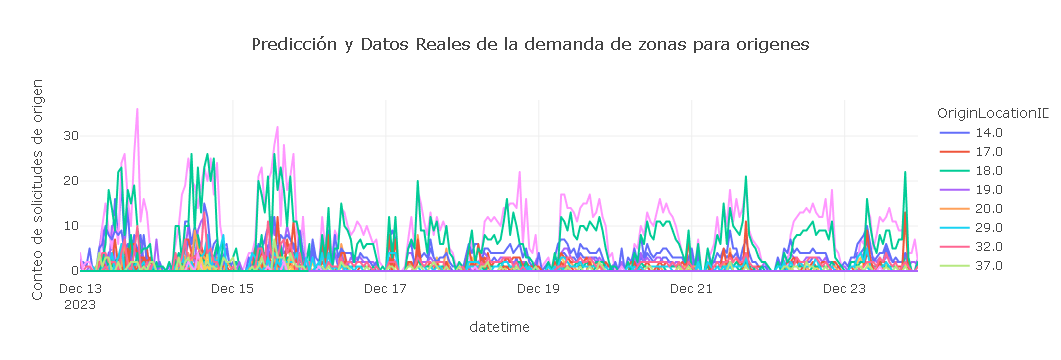

In [497]:
import plotly.express as px
import pandas as pd

# Combina los conjuntos de datos en un solo DataFrame
combined_data = pd.concat([real_data_filtered.assign(DataType='Predicción'),
                           filtered_data.assign(DataType='Datos Reales')])

# Define una paleta de colores personalizada
custom_colors = px.colors.qualitative.Plotly

# Crea un gráfico interactivo con Plotly
fig = px.line(combined_data, x='datetime', y='origin_request_count', color='OriginLocationID',
              labels={'origin_request_count': 'Conteo de solicitudes de origen'},
              title='Predicción y Datos Reales de la demanda de zonas para origenes',
              color_discrete_sequence=custom_colors,
              line_group='OriginLocationID',
              )

# Añade configuraciones adicionales para la línea de datos reales
fig.update_traces(line=dict(dash='solid', width=2), selector=dict(type='scatter', name='Datos Reales'))

# Muestra el gráfico interactivo en el navegador
fig.show()


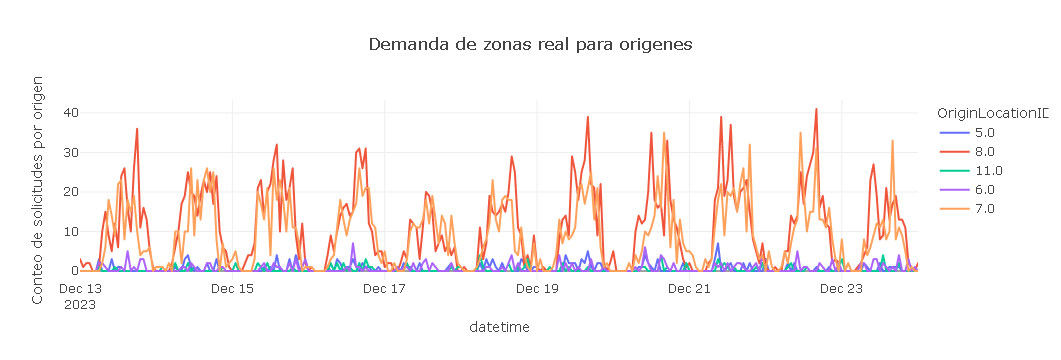

In [472]:

import plotly.express as px

# Lista de OriginLocationID que deseas excluir (reemplaza con los valores que desees excluir)
ids_to_exclude = [1, 2, 3, 4, 10]

# Filtra por OriginLocationID excluyendo los especificados en ids_to_exclude
filtered_data = data_completed[~data_completed['OriginLocationID'].isin(ids_to_exclude)]

# Define una paleta de colores personalizada
custom_colors = px.colors.qualitative.Plotly

# Crea un gráfico interactivo con Plotly
fig = px.line(filtered_data, x='datetime', y='origin_request_count', color='OriginLocationID',
              labels={'origin_request_count': 'Conteo de solicitudes por origen'},
              title='Demanda de zonas real para origenes',
              color_discrete_sequence=custom_colors)


# Muestra el gráfico interactivo en el navegador
fig.show()


In [481]:
# Leer el archivo CSV
forcast_df = pd.read_csv('D:/trufiapp/GANS/forecast/forcast_data.csv', parse_dates=['hourly_timestamp'])

# Cambiar el nombre de la columna 'hourly_timestamp' a 'datetime'
forcast_df = forcast_df.rename(columns={'hourly_timestamp': 'datetime'})
forcast_df

datetime          1          2          3          4         10
0   2023-12-16 00:00:00   2.255799   4.206764   6.635908   2.721758   1.603665
1   2023-12-16 01:00:00   1.081764   2.209173   3.138490   0.856987   0.781014
2   2023-12-16 02:00:00   0.959975   1.743494   2.336351   0.719181   0.568928
3   2023-12-16 03:00:00   0.521205   0.959188   1.131019   0.494547   0.124936
4   2023-12-16 04:00:00   0.468963   0.884186   0.913727   0.640898  -0.019329
..                  ...        ...        ...        ...        ...        ...
163 2023-12-22 19:00:00  12.182293  23.435816  41.868281  12.007822  11.628883
164 2023-12-22 20:00:00   7.893982  14.919242  26.443365   8.049865   7.365559
165 2023-12-22 21:00:00   6.254036  11.297625  19.121961   7.324765   5.281277
166 2023-12-22 22:00:00   4.677292   7.079300  12.087179   5.343876   3.249040
167 2023-12-22 23:00:00   2.647094   4.490187   7.065567   2.959714   1.795437

[168 rows x 6 columns]

In [482]:
filtered_data

datetime  origin_request_count  OriginLocationID  \
14     2023-12-13 00:00:00                   0.0                 5   
18     2023-12-13 00:00:00                   3.0                 8   
21     2023-12-13 00:00:00                   0.0                11   
33     2023-12-13 00:00:00                   0.0                 6   
34     2023-12-13 00:00:00                   0.0                 7   
...                    ...                   ...               ...   
15588  2023-12-24 00:00:00                   0.0                 7   
15605  2023-12-24 00:00:00                   0.0                 6   
15619  2023-12-24 00:00:00                   0.0                 5   
15621  2023-12-24 00:00:00                   2.0                 8   
15624  2023-12-24 00:00:00                   0.0                11   

       destination_request_count  Holiday_n  windspeed  cloudcover  precip  \
14                           2.0        0.0       11.2        89.0     0.0   
18                           3.0        0.0       11.2        89.0     0.0   
21                           0.0        0.0       11.2        89.0     0.0   
33                           0.0        0.0       11.2        89.0     0.0   
34                           3.0        0.0       11.2        89.0     0.0   
...                          ...        ...        ...         ...     ...   
15588                        0.0        0.0       14.8        88.0     0.0   
15605                        1.0        0.0       14.8        88.0     0.0   
15619                        0.0        0.0       14.8        88.0     0.0   
15621                        0.0        0.0       14.8        88.0     0.0   
15624                        0.0        0.0       14.8        88.0     0.0   

       humidity  temp  isWeekend  DayOfWeek  Hour  DayOfMonth  Month    Year  \
14        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
18        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
21        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
33        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
34        52.80  21.0        0.0        4.0   0.0        13.0   12.0  2023.0   
...         ...   ...        ...        ...   ...         ...    ...     ...   
15588     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15605     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15619     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15621     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   
15624     43.43  22.0        1.0        1.0   0.0        24.0   12.0  2023.0   

              h3_index  id   latitude  longitude  
14     878b2c98affffff   5 -17.455051 -66.153015  
18     878b2c8acffffff   8 -17.386101 -66.188359  
21     878b2c99dffffff  11 -17.466841 -66.133964  
33     878b2c998ffffff   6 -17.455962 -66.113539  
34     878b2c8a8ffffff   7 -17.363420 -66.186976  
...                ...  ..        ...        ...  
15588  878b2c8a8ffffff   7 -17.363420 -66.186976  
15605  878b2c998ffffff   6 -17.455962 -66.113539  
15619  878b2c98affffff   5 -17.455051 -66.153015  
15621  878b2c8acffffff   8 -17.386101 -66.188359  
15624  878b2c99dffffff  11 -17.466841 -66.133964  

[1325 rows x 20 columns]

In [486]:
# Convertir OriginLocationID a tipo entero
filtered_data['OriginLocationID'] = filtered_data['OriginLocationID'].astype(int)

# Seleccionar las columnas deseadas
filtered_data_selected = filtered_data[['datetime', 'origin_request_count', 'OriginLocationID']]

# Utilizar pivot para convertir OriginLocationID en columnas
pivot_data = filtered_data_selected.pivot(index='datetime', columns='OriginLocationID', values='origin_request_count')

# Resetear el índice si se desea
pivot_data.reset_index(inplace=True)

# Mostrar el DataFrame resultante
pivot_data


OriginLocationID             datetime    5    6    7     8   11
0                 2023-12-13 00:00:00  0.0  0.0  0.0   3.0  0.0
1                 2023-12-13 01:00:00  0.0  0.0  0.0   1.0  0.0
2                 2023-12-13 02:00:00  0.0  0.0  0.0   2.0  0.0
3                 2023-12-13 03:00:00  0.0  0.0  0.0   2.0  0.0
4                 2023-12-13 04:00:00  0.0  0.0  0.0   0.0  0.0
..                                ...  ...  ...  ...   ...  ...
260               2023-12-23 20:00:00  0.0  0.0  5.0  11.0  0.0
261               2023-12-23 21:00:00  0.0  3.0  0.0   2.0  0.0
262               2023-12-23 22:00:00  0.0  0.0  1.0   1.0  0.0
263               2023-12-23 23:00:00  0.0  1.0  0.0   0.0  0.0
264               2023-12-24 00:00:00  0.0  0.0  0.0   2.0  0.0

[265 rows x 6 columns]

In [487]:
import pandas as pd

# Lee el DataFrame del archivo CSV
forecast_data = pd.read_csv('D:/trufiapp/GANS/forecast/forcast_data.csv', parse_dates=['hourly_timestamp'])

forecast_data = forecast_data.rename(columns={'hourly_timestamp': 'datetime'})

forecast_data['datetime'] = pd.to_datetime(forecast_data['datetime'])  # Convierte el tipo de datos
pivot_data['datetime'] = pd.to_datetime(pivot_data['datetime'])  # Convierte el tipo de datos

# Combina ambos DataFrames utilizando la columna 'datetime'
combined_data = pd.merge(forecast_data, pivot_data, on='datetime', how='left')

combined_data

datetime          1          2          3          4  \
0   2023-12-16 00:00:00   2.255799   4.206764   6.635908   2.721758   
1   2023-12-16 01:00:00   1.081764   2.209173   3.138490   0.856987   
2   2023-12-16 02:00:00   0.959975   1.743494   2.336351   0.719181   
3   2023-12-16 03:00:00   0.521205   0.959188   1.131019   0.494547   
4   2023-12-16 04:00:00   0.468963   0.884186   0.913727   0.640898   
..                  ...        ...        ...        ...        ...   
163 2023-12-22 19:00:00  12.182293  23.435816  41.868281  12.007822   
164 2023-12-22 20:00:00   7.893982  14.919242  26.443365   8.049865   
165 2023-12-22 21:00:00   6.254036  11.297625  19.121961   7.324765   
166 2023-12-22 22:00:00   4.677292   7.079300  12.087179   5.343876   
167 2023-12-22 23:00:00   2.647094   4.490187   7.065567   2.959714   

            10    5    6     7     8   11  
0     1.603665  0.0  0.0   1.0   0.0  0.0  
1     0.781014  0.0  0.0   1.0   1.0  0.0  
2     0.568928  0.0  0.0   0.0   0.0  0.0  
3     0.124936  0.0  0.0   0.0   0.0  0.0  
4    -0.019329  0.0  0.0   0.0   0.0  0.0  
..         ...  ...  ...   ...   ...  ...  
163  11.628883  0.0  0.0  11.0  12.0  0.0  
164   7.365559  1.0  0.0  16.0  11.0  0.0  
165   5.281277  0.0  3.0   8.0   2.0  0.0  
166   3.249040  0.0  0.0   3.0   3.0  0.0  
167   1.795437  0.0  2.0   0.0   2.0  1.0  

[168 rows x 11 columns]

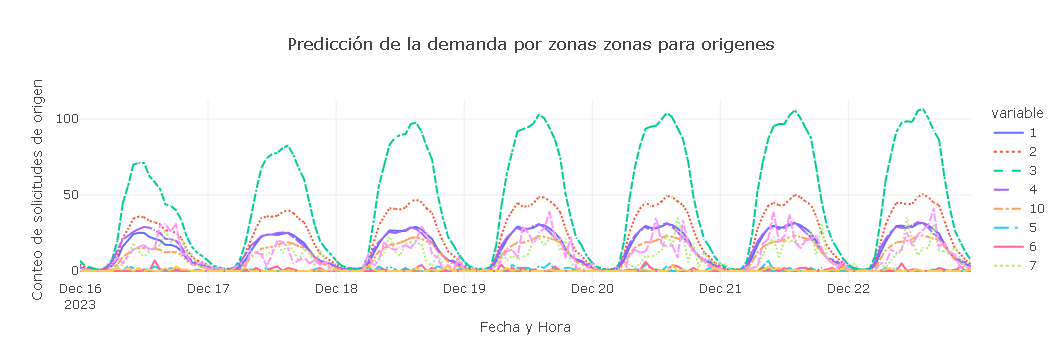

In [479]:
import plotly.express as px

# Obtén el nombre de las columnas que no son 'datetime'
y_columns = combined_data.columns[1:]

# Define una paleta de colores personalizada
custom_colors = px.colors.qualitative.Plotly

fig = px.line(combined_data, x='datetime', y=y_columns,
              labels={'value': 'Conteo de solicitudes por origen'},
              title='Predicción de la demanda por zonas zonas para origenes',
              line_dash='variable',
              color_discrete_sequence=custom_colors)

fig.update_layout(xaxis_title='Fecha y Hora', yaxis_title='Conteo de solicitudes de origen')

# Muestra el gráfico interactivo en el navegador
fig.show()


In [235]:
import folium
import pandas as pd
import h3
import geopandas as gpd
from shapely.geometry import Polygon

In [371]:

# Función para obtener el índice H3 y las coordenadas
def get_h3_index_and_coords(latitude, longitude, resolution=7):
    h3_index = h3.geo_to_h3(latitude, longitude, resolution)
    coords = h3.h3_to_geo(h3_index)
    return h3_index, coords

# Directorio y nombres de archivos
repo = r'D:\trufiapp\GANS'
csv_file_path = os.path.join(repo, 'route_info.csv')
csv_save_file_path = os.path.join(repo, 'id_index_h3.csv')
output_dir = os.path.join(repo, 'cochabamba_data')  # Nuevo directorio para la data modificada
output_file_path = os.path.join(output_dir, 'cochabamba_data.csv')  # Ruta completa al archivo CSV

# Lee el DataFrame del archivo CSV
forecast_data = pd.read_csv('D:/trufiapp/GANS/forecast/forcast_data.csv', parse_dates=['hourly_timestamp'])
# Lee el DataFrame del archivo CSV
df_h3_data = pd.read_csv('D:/trufiapp/GANS/id_index_h3.csv')

In [372]:
df_h3_data

h3_index   id   latitude  longitude
0    878b2c8a1ffffff    1 -17.397907 -66.169306
1    878b2c8aeffffff    2 -17.375229 -66.167926
2    878b2c8a3ffffff    3 -17.387033 -66.148877
3    878b2c8a0ffffff    4 -17.409708 -66.150256
4    878b2c98affffff    5 -17.455051 -66.153015
..               ...  ...        ...        ...
492  87b32d9a3ffffff  493 -17.637221 -66.124556
493  87b32d9a2ffffff  494 -17.625458 -66.143617
494  87b32d823ffffff  495 -17.719424 -65.991200
495  87b32d826ffffff  496 -17.685064 -66.008876
496  878b2c934ffffff  497 -17.657234 -66.244507

[497 rows x 4 columns]

In [445]:
# Función para obtener los polígonos H3
def get_h3_polygons(df):
    polygons = []
    for index, row in df.iterrows():
        h3_index = row['h3_index']
        hexagon = h3.h3_to_geo_boundary(h3_index)
        polygon_coords = [(coord[1], coord[0]) for coord in hexagon]  # Corregir el orden de las coordenadas
        polygons.append(Polygon(polygon_coords))
    return gpd.GeoDataFrame(df, geometry=polygons, crs="EPSG:4326")

# Obtener GeoDataFrame con polígonos
gdf_h3_polygons = get_h3_polygons(df_h3_data)

df = pd.DataFrame(combined_data)
df['datetime'] = pd.to_datetime(df['datetime'])

# Utilizar melt para desnormalizar
df_desnormalized = df.melt(id_vars=['datetime'], var_name='id', value_name='request_origin_quantity')


In [446]:
# pip install Flask Flask-SocketIO


In [449]:
gdf_h3_polygons['id'] = gdf_h3_polygons['id'].astype('int64')

# Fusionar df_desnormalized con gdf_h3_polygons mediante la columna 'id'
merged_df = pd.merge(df_desnormalized, gdf_h3_polygons[['id', 'geometry','h3_index','latitude']], on='id')df_desnormalized.join(gdf_h3_polygons.set_index('id'), on='id')

# Crear un GeoDataFrame a partir del DataFrame fusionado
gdf_merged = gpd.GeoDataFrame(merged_df, geometry='geometry')

gdf_merged.tail(30)

SyntaxError: invalid syntax (1341908453.py, line 4)

In [406]:
# jupyter serverextension enable --py nbserverproxy

SyntaxError: invalid syntax (3178037811.py, line 1)

In [428]:
gdf_merged

datetime  id  request_origin_quantity         h3_index  \
0    2023-12-16 00:00:00   1                 2.255799  878b2c8a1ffffff   
1    2023-12-16 01:00:00   1                 1.081764  878b2c8a1ffffff   
2    2023-12-16 02:00:00   1                 0.959975  878b2c8a1ffffff   
3    2023-12-16 03:00:00   1                 0.521205  878b2c8a1ffffff   
4    2023-12-16 04:00:00   1                 0.468963  878b2c8a1ffffff   
...                  ...  ..                      ...              ...   
1843 2023-12-22 19:00:00  11                 0.000000  878b2c99dffffff   
1844 2023-12-22 20:00:00  11                 0.000000  878b2c99dffffff   
1845 2023-12-22 21:00:00  11                 0.000000  878b2c99dffffff   
1846 2023-12-22 22:00:00  11                 0.000000  878b2c99dffffff   
1847 2023-12-22 23:00:00  11                 1.000000  878b2c99dffffff   

       latitude  longitude                                           geometry  
0    -17.397907 -66.169306  POLYGON ((-66.17520 -17.38641, -66.18247 -17.3...  
1    -17.397907 -66.169306  POLYGON ((-66.17520 -17.38641, -66.18247 -17.3...  
2    -17.397907 -66.169306  POLYGON ((-66.17520 -17.38641, -66.18247 -17.3...  
3    -17.397907 -66.169306  POLYGON ((-66.17520 -17.38641, -66.18247 -17.3...  
4    -17.397907 -66.169306  POLYGON ((-66.17520 -17.38641, -66.18247 -17.3...  
...         ...        ...                                                ...  
1843 -17.466841 -66.133964  POLYGON ((-66.13985 -17.45536, -66.14712 -17.4...  
1844 -17.466841 -66.133964  POLYGON ((-66.13985 -17.45536, -66.14712 -17.4...  
1845 -17.466841 -66.133964  POLYGON ((-66.13985 -17.45536, -66.14712 -17.4...  
1846 -17.466841 -66.133964  POLYGON ((-66.13985 -17.45536, -66.14712 -17.4...  
1847 -17.466841 -66.133964  POLYGON ((-66.13985 -17.45536, -66.14712 -17.4...  

[1848 rows x 7 columns]

In [412]:
# pip install dash


In [521]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import folium
from folium import plugins
import h3
import pandas as pd

# Inicializar la aplicación Dash
app = dash.Dash(__name__)

# Crear un mapa con folium
mapa = folium.Map(location=[-17.4, -66.16], zoom_start=12)

# Agregar un control de dibujo al mapa
draw_control = plugins.Draw(export=True)
draw_control.add_to(mapa)

# Agregar un control de capas para cambiar entre diferentes mapas base
folium.TileLayer('openstreetmap').add_to(mapa)

# Conjunto para realizar un seguimiento de hexágonos impresos
printed_hexagons = set()

# Diccionario para almacenar la suma de cantidades por id
sum_by_id = {}

# Diseño de la aplicación Dash
app.layout = html.Div([
    html.Div([
        html.Label("Fecha y Hora:"),
        dcc.Slider(
            id="date-slider",
            min=min_date.timestamp(),
            max=max_date.timestamp(),
            step=3600,  # Incremento de 1 hora
            marks={int(min_date.timestamp()): min_date.strftime('%Y-%m-%d %H:%M'),
                   int(max_date.timestamp()): max_date.strftime('%Y-%m-%d %H:%M')},
            value=min_date.timestamp()  # Valor inicial, puedes ajustarlo según tus necesidades
        ),
        html.Div(id="selected-date-output")  # Componente de texto para mostrar la fecha seleccionada
    ]),
    html.Div([
        html.Iframe(
            id='map-iframe',
            srcDoc=mapa._repr_html_(),  # Obtener el HTML del mapa de Folium
            width='100%',
            height='600'
        ),
    ]),
])

# Callback para actualizar el mapa y mostrar la fecha seleccionada
@app.callback(
    [Output('map-iframe', 'srcDoc'),
     Output('selected-date-output', 'children')],
    Input('date-slider', 'value')
)
def update_map_callback(selected_date):
    # Convertir el valor del slider a un objeto datetime
    selected_datetime = pd.to_datetime(selected_date, unit='s')

    # Filtrar el DataFrame por la fecha seleccionada
    df_filtered = gdf_merged[gdf_merged['datetime'] == selected_datetime]

    for hexagon in printed_hexagons:
        mapa.get_root().html.add_child(folium.Element(f'<script>map.removeLayer({hexagon});</script>'))

    printed_hexagons.clear()
    sum_by_id.clear()

    for idx, row in df_filtered.iterrows():
        hexagon_coords = h3.h3_to_geo_boundary(row['h3_index'])

        if row['id'] in sum_by_id:
            sum_by_id[row['id']] += row['request_origin_quantity']
        else:
            sum_by_id[row['id']] = row['request_origin_quantity']

        if row['h3_index'] not in printed_hexagons:
            add_polygon_with_label(mapa, hexagon_coords, row['id'], sum_by_id[row['id']])
            printed_hexagons.add(row['h3_index'])

    # Devolver el HTML del mapa y la fecha seleccionada
    return mapa._repr_html_(), f"Fecha seleccionada: {selected_datetime.strftime('%Y-%m-%d %H:%M')}"


# Ejecutar la aplicación Dash
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

